<a href="https://colab.research.google.com/github/DungDuc/MEDNet/blob/main/MEDNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Readme
In this notebook, you could:

* Access the data and checkpoints from the following link: https://shorturl.at/X1MKi

* Copy data and checkpoint files to your system, e.g. Google Drive.

* Use the data and models for testing or re-experiment, e.g. mount the Google Drive and run the following cells on Google Colab.


# Import

In [1]:
# import library
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Concatenate, Multiply, Flatten, MaxPooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Attention
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, ReLU, Dense
from tensorflow.keras.layers import Add, Multiply, Reshape, DepthwiseConv2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K

from google.colab.patches import cv2_imshow
from IPython.display import clear_output

import glob
import os
import cv2
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml
import xml.etree.ElementTree as ET
import struct
import csv



# API

In [2]:
# class labels and colors
AllTags = ['Reg1', 'Reg2', 'Reg3',\
        'Reg4', 'Reg5', 'Reg6',\
        'Reg7', 'Reg8', 'Reg9']

#Colors = [[255,0,0], [0,255,0], [0,0,255],\
#Colors = [[0,255,0], [0,0,255], [255,0,0],\
Colors = [[0,0,255], [255,0,0], [0,255,0], \
          [255,255,0], [255,0,255], [0,255,255],\
          [128,0,0], [0,128,0], [0,0,128],\
          [255,255,255]]
MaxColor = len(Colors)-1

def set_label(Tags):
    # class name and colors
    nColor = len(Colors)
    for i in range(len(Tags)):
        class_names.append(Tags[i])
        label_values.append(Colors[i%nColor])
    # background
    class_names.append('Background')
    label_values.append([255,255,255])

class_names, label_values = [],[]
set_label(AllTags)

# one-hot and colour coding
def one_hot_it(code, num_classes):
    masks = []
    for i in range(num_classes):
        mi = np.uint8((code==i))*1
        masks.append(mi)
    return np.stack(masks, axis=-1)

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1).astype(np.uint16)
    return x

def colour_code_segmentation(img, MaxClass=0):
    image = img.copy()
    colour_codes = np.array(label_values).astype(np.uint8)
    if MaxClass > 0:
      image[image==MaxClass] = MaxColor
    x = colour_codes[image.astype(np.uint16)]
    return x


class Region(object):
    def __init__(self, tag = None, xmin=None, ymin=None, xmax=None, ymax=None, poly=None):
        self.tag = tag
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.poly = poly
    def iou(self, other):
        if self.poly is not None and other.poly is not None:
            return poly_iou(self.poly, other.poly)
        else:
            return 0

def bb_iou(regA, regB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xLeft = max(regA.xmin, regB.xmin)
    yLeft = max(regA.ymin, regB.ymin)
    xRight = min(regA.xmax, regB.xmax)
    yRight = min(regA.ymax, regB.ymax)

    if xLeft > xRight or yLeft > yRight:
      return 0

    # compute the area of intersection rectangle
    interArea = max(0, xRight - xLeft + 1) * max(0, yRight - yLeft + 1)
    # compute the area of both the prediction and ground-truthrectangles
    boxAArea = (regA.xmax - regA.xmin + 1) * (regA.ymax - regA.ymin + 1)
    boxBArea = (regB.xmax - regB.xmin + 1) * (regB.ymax - regB.ymin + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


def GetFiles(Folders, ext):
    Files = []
    for folder in Folders:
        files = glob.glob(folder + '/*.' + ext)
        files.sort()
        Files.extend(files)
    return Files

def ResizeImg(img, height, width):
    img_h, img_w = img.shape[0], img.shape[1]
    scale = min(float(height) / img_h, float(width) / img_w)

    img = cv2.resize(img, (int(scale*img_w), (int(scale*img_h))))
    if img.shape[1] < width:
        img = cv2.copyMakeBorder(img, 0, 0, 0, width - img.shape[1], cv2.BORDER_REPLICATE)
    if img.shape[0] < height:
        img = cv2.copyMakeBorder(img, 0, height - img.shape[0], 0, 0, cv2.BORDER_REPLICATE)

    if img.ndim < 3:
        img = np.expand_dims(img, axis=-1)

    return img, scale

def Binary(ImgIn):
    if ImgIn.shape[-1] == 3:
      gray = cv2.cvtColor(ImgIn, cv2.COLOR_RGB2GRAY)
    else:
      gray = ImgIn[...,0]

    #ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)

    return thresh

def ViewImgs(Imgs):
    fig = plt.figure(figsize=(15, 15))
    for i in range(len(Imgs)):
        plt.subplot(1, len(Imgs), i+1)
        if Imgs[i].ndim == 3:
            if  Imgs[i].shape[-1] == 3:
              plt.imshow(Imgs[i])
            else:
              plt.imshow(Imgs[i][...,0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(Imgs[i], cmap='gray', vmin=0, vmax=255)
    plt.show()


def MasksImg(masks, img=None):
    masks_img = colour_code_segmentation(reverse_one_hot(masks), MaxClass=masks.shape[-1]-1)
    # resize mask
    if img is not None:
        if img.shape[0] != masks_img.shape[0] or img.shape[1] != masks_img.shape[1]:
            #masks_img,_ = ResizeImg(masks_img, img.shape[0], img.shape[1])
            img,_ = ResizeImg(img, masks_img.shape[0], masks_img.shape[1])
        masks_img = ((0.5 * img) + (0.5 * masks_img)).astype("uint8")
        masks_img = np.minimum(masks_img, img)

    return masks_img


def hex_to_double(hStr):
    return struct.unpack("d", struct.pack("Q",int("0x"+hStr, 16)))[0]

# adjust ground truth
def AdjustGTs(regions, bw):
  for i, rg in enumerate(regions):
      regions[i] = AdjustGT(rg, bw)
  return regions


def AdjustGT(rg, bw):
    # left-right
    m = 4
    rg.xmin -= m
    rg.xmax += m
    roi = bw[rg.ymin:rg.ymax, rg.xmin:rg.xmax]
    hist = np.sum((255-roi)/255,axis=0)
    len_h = len(hist)

    # find the closest white line
    left_ws = np.array([i for i in range(0,2*m) if (hist[i] == 0 and i < len_h//2)])
    right_ws = np.array([i for i in range(len_h-2*m, len_h) if (hist[i] == 0 and i > len_h//2)])

    left, right = m, len_h-m
    if len(left_ws) > 0:
        left = min(left_ws, key=lambda x:abs(x-left))
    if len(right_ws) > 0:
        right = min(right_ws, key=lambda x:abs(x-right))


    while left < right and hist[left] == 0:
        left += 1
    left -= 1
    while right > left and hist[right] == 0:
        right -= 1
    right += 1

    rg.xmin += left
    rg.xmax -= (len_h - right)

    # top-bottom
    m = 8
    rg.ymin -= m
    rg.ymax += m
    roi = bw[rg.ymin:rg.ymax, rg.xmin:rg.xmax]
    hist = np.sum((255-roi)/255,axis=1)
    len_h = len(hist)

    # find the closest white line
    top_ws = np.array([i for i in range(0,2*m) if (hist[i] == 0 and i < len_h//2)])
    bot_ws = np.array([i for i in range(len_h-2*m, len_h) if (hist[i] == 0 and i > len_h//2)])

    top, bot = m, len_h-m
    if len(top_ws) > 0:
        top = min(top_ws, key=lambda x:abs(x-top))
    if len(bot_ws) > 0:
        bot = min(bot_ws, key=lambda x:abs(x-bot))

    while top < bot and hist[top] == 0:
        top += 1
    top -= 1
    while bot > top and hist[bot] == 0:
        bot -= 1
    bot +=1

    rg.ymin += top
    rg.ymax -= (len_h - bot)

    return rg

# data normalization
Norm = lambda x: np.float32(x)/np.max(x)

class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:],
                                     initializer=tf.random_normal_initializer(1., 0.02),
                                     trainable=True)

        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros',
                                      trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset


def UpScaling(x, scale):
    x = UpSampling2D(size=[scale, scale], interpolation='bilinear')(x)
    return x



# Data label

In [3]:
# single-label masks
def Reg2MaskSL(Regions, img):
    img_h, img_w = img.shape[0:2]
    seg_bg = (np.zeros((img_h, img_w), np.uint8) * 255)
    seg_masks = []
    for c in range(num_classes):
        # class mask
        mask_c = np.zeros((img_h, img_w), np.uint8)
        for reg in Regions:
            if int(reg.tag) == c:
                mask_c[reg.ymin:reg.ymax, reg.xmin:reg.xmax] = 255
        # augmented mask
        seg_masks.append(mask_c)
        seg_bg = np.maximum(seg_bg, mask_c)

    # all classes
    seg_masks.append(255 - seg_bg)

    return np.stack(seg_masks, axis=-1)


# multiple-label masks
def Reg2MaskML(Regions, bw):
    img_h, img_w = bw.shape[0:2]
    seg_fg = (np.zeros((img_h, img_w), np.uint8) * 255)
    det_fg = (np.zeros((img_h, img_w), np.uint8) * 255)

    seg_masks, detect_masks = [], []
    for c in range(num_classes):
        # class mask
        mask_c = np.zeros((img_h, img_w), np.uint8)
        for reg in Regions:
            if int(reg.tag) == c:
                mask_c[reg.ymin:reg.ymax, reg.xmin:reg.xmax] = 255

        # augmented mask
        fg_c = mask_c
        margin = 4
        if c == 1 or c == 0:
            fg_c = np.uint8(((255-bw)*(mask_c==255)))
            fg_c = cv2.dilate(fg_c, np.ones((2*margin+1, 2*margin+1), np.uint8))
            fg_c = cv2.morphologyEx(fg_c, cv2.MORPH_CLOSE, np.ones((2*margin+1, 4*margin+1), np.uint8))
            fg_c *= (mask_c==255)

        # detection mask
        det_fg = np.maximum(det_fg, fg_c)

        # segmentation mask
        fg_c = mask_c
        seg_masks.append(fg_c)
        seg_fg = np.maximum(seg_fg, fg_c)

    # all classes
    seg_masks.append(255 - seg_fg)
    detect_masks.append(det_fg)
    detect_masks.append(255 - det_fg)

    AllMask = [det_fg]
    AllMask.extend(seg_masks)

    #return np.stack(seg_masks, axis=-1), np.stack(detect_masks, axis=-1)
    return np.stack(AllMask, axis=-1), np.stack(detect_masks, axis=-1)


def ViewData(data_fn, LoadDataFunct):
    img, y_seg, y_detect, RegionsGT = MEDLoadData(data_fn, LoadDataFunct, INPUT_H, INPUT_W, INPUT_C)

    y_img = img
    if img.shape[-1] == 1:
        y_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for rg in RegionsGT:
        cv2.rectangle(y_img, (int(rg.xmin), int(rg.ymin)), (int(rg.xmax), int(rg.ymax)), Colors[int(rg.tag)], 1)

    y_sseg = Reg2MaskSL(RegionsGT, img)
    y_sseg_img = MasksImg(y_sseg, img)

    y_seg_img = MasksImg(y_seg, img)
    y_det_img = MasksImg(y_detect, img)

    cv2_imshow(y_img)
    ViewImgs([y_img, y_det_img, y_seg_img])


def MEDLoadData(data_fn, LoadDataFunct, img_h=0, img_w=0, img_c=0):
    # image and GT
    img, RegionsGT = LoadDataFunct(data_fn)
    if img is not None:
        # size normalize
        if img_h > 0 and img_w > 0:
            img, scale = ResizeImg(img, img_h, img_w)

            for i, r in enumerate(RegionsGT):
                r.xmin = int(r.xmin*scale)
                r.xmax = int(r.xmax*scale)
                r.ymin = int(r.ymin*scale)
                r.ymax = int(r.ymax*scale)
                RegionsGT[i] = r

        # adjust ground truth
        bw = Binary(img)
        RegionsGT = AdjustGTs(RegionsGT, bw)

        # regions to mask
        y_seg, y_detect = Reg2MaskML(RegionsGT, bw)

        if img_c == 1:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = np.expand_dims(img, axis=-1)

        return img, y_seg, y_detect, RegionsGT

    return None, None, None, None

# MEDNet

In [4]:
def MEDNet(input_shape, nClass, nFeatures=128,
           scale1=1, scale2=3, ext=3, first_filters=32, nConv=3):
    # input
    inputs = Input(shape=input_shape)

    # features
    features = FeatExtractor(inputs, depth=scale2+ext, first_filters=first_filters, nConv=nConv)
    s1_feats, s2_feats = [], []
    for i in range(ext):
        s1_feats.append(UpScaling(features[scale1+i], 2**(i+1)))
        s2_feats.append(UpScaling(features[scale2+i], 2**(i+1)))

    s1_feats = Concatenate()(s1_feats)
    s1_feats = ConvBlocks(s1_feats, nFeatures, kernel_size=1, stride=1, nConv=1)
    s2_feats = Concatenate()(s2_feats)
    s2_feats = ConvBlocks(s2_feats, nFeatures, kernel_size=1, stride=1, nConv=1)

    # scale1 detection map
    s1_feats, s1_map = SegHead(s1_feats, nFeatures, out_ch=2, nConv=0)
    s1_map = Activation('sigmoid', name="y1")(s1_map)

    # scale2 segmentation map
    s2_feats, s2_map = SegHead(s2_feats, nFeatures, out_ch=nClass+2, nConv=0)
    s2_map = Activation('sigmoid', name="y2")(s2_map)

    # combined feature maps
    s2_feats = UpScaling(s2_feats, 2 ** (scale2 - scale1))
    s12_feats = Concatenate()([s1_feats, s2_feats])
    s12_feats = ConvBlocks(s12_feats, nFeatures, kernel_size=1, stride=1, nConv=1)

    # final segmentation map
    s12_feats, seg_map = SegHead(s12_feats, nFeatures, out_ch=nClass+2, nConv=3)
    seg_map = UpScaling(seg_map, 2 ** scale1)
    seg_map = Activation('sigmoid', name="y")(seg_map)

    return Model(inputs=inputs, outputs=[seg_map, s1_map, s2_map])


def SegHead(x, filters, out_ch=1, nConv=1, DropRate=0.2):
    if nConv > 0:
        x = ConvBlocks(x, filters, kernel_size=(3,3), nConv=nConv, DropRate=DropRate)

    seg_map = Conv2D(out_ch, kernel_size=3, strides=1, padding='same')(x)
    return x, seg_map


def FeatExtractor(x, depth=5, first_filters=32, nConv=2):
    features = []
    filters = first_filters
    for i in range(depth):
        if i == 0:
            x = ConvBlocks(x, filters, kernel_size=(7,5), stride=2, nConv=nConv)
            filters *= 2
            nConv += 1
        else:
            x = K_ConvBlocks(x, filters, [(3, 3), (3, 7)], nConv=nConv)
            x = MaxPooling2D()(x)

        features.append(x)

    return features


# convolution blocks
def K_ConvBlocks(x, filters, kernel_sizes, nConv=2, NormType='instance', DropRate=0.2):
    maps = []
    for k in kernel_sizes:
        m = ConvBlocks(x, filters//2, kernel_size=k, stride=1, nConv=nConv, NormType=NormType, DropRate=DropRate)
        maps.append(m)
    map = Concatenate()(maps)
    map = ConvBlocks(map, filters, kernel_size=1, stride=1, nConv=1, NormType=NormType, DropRate=DropRate)

    return map

def ConvBlocks(x, filters, kernel_size=(3, 3), dilation_rate=1, stride=1, nConv=1, NormType='instance', DropRate=0.2):
    # first conv
    x = Conv_BN_Act(filters, kernel_size=kernel_size, dilation_rate=dilation_rate,stride=stride,
                    NormType=NormType, DropRate=DropRate)(x)
    # stride-1 convolution
    for i in range(1, nConv):
        x = Conv_BN_Act(filters, kernel_size=kernel_size, stride=1, NormType=NormType, DropRate=DropRate)(x)

    return x

# Basic convolution block
def Conv_BN_Act(filters, kernel_size=(3, 3), dilation_rate=(1, 1), stride=1, NormType='instance', DropRate=0.2):
    f = Sequential()

    f.add(Conv2D(filters, kernel_size, strides=stride, dilation_rate=dilation_rate, padding='same', use_bias=False))

    if NormType.lower() == 'batch':
        f.add(BatchNormalization())
    elif NormType.lower() == 'instance':
        f.add(InstanceNormalization())

    f.add(ReLU())

    if DropRate > 0.0:
        f.add(Dropout(DropRate))

    return f


In [5]:
# defaut variables
INPUT_H, INPUT_W, INPUT_C = 1472, 1024, 1
input_shape = [INPUT_H, INPUT_W, INPUT_C]
num_classes = 2

scale1, scale2, ext = 1, 3, 3
nConv, first_filters = 3, 64
nFeatures = 128

#act_funct='softmax'
#loss_funct = 'categorical_crossentropy'
#metric = 'accuracy'

act_funct='sigmoid'
loss_funct = 'binary_crossentropy'
metric = 'binary_accuracy'

Metrics = {
    "y": metric,
    "y1": metric,
    "y2": metric,
}

Losses = {
    "y": loss_funct,
    "y1": loss_funct,
    "y2": loss_funct,
}

def BuildModel():
    model = MEDNet(input_shape, num_classes, nFeatures=nFeatures,
                   scale1=scale1, scale2=scale2, ext=ext, first_filters=first_filters, nConv=nConv)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    #radam = tfa.optimizers.RectifiedAdam()
    #ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    #optimizer = ranger

    model.compile(loss=Losses, optimizer=optimizer, metrics=Metrics)

    return model


# test
model = BuildModel()
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1472, 1024, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 736, 512, 64)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 736, 512, 64)   │        143,488 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 736, 512, 64)   │        143,488 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 736, 512, 64)   │         36,992 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 736, 512, 64)   │         86,144 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 736, 512, 64)   │         36,992 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 736, 512, 64)   │         86,144 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 736, 512, 64)   │         36,992 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 736, 512, 64)   │         86,144 │ sequential_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 736, 512, 64)   │         36,992 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 736, 512, 64)   │         86,144 │ sequential_9[0][0]     │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 736, 512, 128)  │              0 │ sequential_6[0][0],    │
│                           │                        │                │ sequential_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 736, 512, 128)  │         16,640 │ concatenate[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 368, 256, 128)  │              0 │ sequential_11[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_12             │ (None, 368, 256, 64)   │         73,856 │ max_pooling2d[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 368, 256, 64)   │        172,160 │ max_pooling2d[0][0]    │
│ (Sequential)         

 Total params: 3,913,290 (14.93 MB)

 Trainable params: 3,913,290 (14.93 MB)

 Non-trainable params: 0 (0.00 B)

# Test API

In [6]:
MIN_W, MIN_H = 5, 7

def Predict(model, img):
    x = img
    if INPUT_C == 1 and len(x.shape) == 3 and x.shape[-1] == 3:
        x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    if x.shape[0] != INPUT_H or x.shape[1] != INPUT_W:
        x, scale = ResizeImg(x, INPUT_H, INPUT_W)
    x = Norm(x)
    x = np.expand_dims(x, axis=0)
    return model.predict(x, verbose=0)


def SampleTest(model, img_fn, num_classes=1, FileName=None, thresh=0.7, debug=True):
    Imgs = []
    # load data
    img, seg_masks, det_masks, RegionsGT = MEDLoadData(img_fn, LoadDataFunct, INPUT_H, INPUT_W, INPUT_C)
    if img is None:
       return None, None, None, None, None

    y_img = MasksImg(seg_masks, img)

    # predict
    yy_seg, yy_seg1, yy_seg2 = Predict(model, img)
    yy_seg = yy_seg[0]
    yy_det_masks = yy_seg1[0]
    yy_seg[yy_seg >= 0.5] = 1

    # detection
    #RegionsPD = GetRegionsPD(yy_seg, num_classes, img)
    RegionsPD = GetRegionsPD(yy_seg[...,1:], num_classes, img)

    # performance
    IoUs, TPRegs, nPos, nPred, nTP = MatchRegs(RegionsGT, RegionsPD, num_classes, thresh)

    if debug and ((nTP[0] != nPos[0] or nTP[0] != nPred[0]) or (num_classes > 1  and (nTP[1] != nPos[1] or nTP[1] != nPred[1]))):
        print(nPos, nPred, nTP)

        # visualize
        yy_seg[yy_seg >= 0.5] = 1
        yy_img = MasksImg(yy_seg, img)

        for rg in RegionsGT:
            cv2.rectangle(yy_img, (int(rg.xmin), int(rg.ymin)), (int(rg.xmax), int(rg.ymax)), Colors[int(rg.tag)+1], 1)
        for rg in RegionsPD:
            cv2.rectangle(yy_img, (int(rg.xmin), int(rg.ymin)), (int(rg.xmax), int(rg.ymax)), Colors[int(rg.tag)+1], 1)
        cv2_imshow(yy_img)

    return nPos, nPred, nTP


def ModelTest(model, FileNames, num_classes, thresh=0.7, debug=False):
    print("Testing...")
    nPositive = np.zeros(num_classes)
    nPredicted = np.zeros(num_classes)
    nTruePos = np.zeros(num_classes)
    MissErrs, WrongErrs = [], []
    for (idx, img_fn) in enumerate(FileNames):
        nPos, nPred, nTP = SampleTest(model, img_fn, num_classes=num_classes, thresh=thresh, debug=debug)
        if nPos is not None:
            nPositive += nPos
            nPredicted += nPred
            nTruePos += nTP

            # inspect result
            if (nTP[0] != nPos[0] or nTP[0] != nPred[0]) or (num_classes > 1  and (nTP[1] != nPos[1] or nTP[1] != nPred[1])):
                print(idx, nPos, nPred, nTP)

    # end of for
    if len(FileNames) > 0:
        Recall = nTruePos/nPositive
        Precision = nTruePos/nPredicted
        F1  = []
        for i in range(len(Precision)):
          F1.append(2*Precision[i]*Recall[i]/(Precision[i] + Recall[i]) if Precision[i] + Recall[i] > 0 else 0)

        print("Class: Recall, Precision, F1")
        for i in range(num_classes):
            print("%s: %.2f (%.2f, %.2f)" % (class_names[i], F1[i]*100, Precision[i]*100, Recall[i]*100))


    print(nPositive, nPredicted, nTruePos)
    nTP = sum(nTruePos)
    nPr = sum(nPredicted)
    nPos = sum(nPositive)
    P, R = nTP / nPr, nTP / nPos
    F = 2*P*R/(P + R)
    print("All: %.2f (%.2f, %.2f)" % (F*100, P*100, R*100))


def GetRegionsPD(masks, nClass, x):
    code = reverse_one_hot(masks)
    x_bw = Binary(x)
    Regions = []
    for c in range(nClass):
        c_mask = np.uint8((masks[...,c] >= 0.5))*255

        nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(c_mask)
        c_regions = []
        for i in range(1, nlabels):
            l_mask = (labels == i).astype("uint8") * 255
            l, t = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
            w, h = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            r, b = l + w, t + h

            if (c == 0 and w >= MIN_W and h >= MIN_H) or (c == 1 and w > 32 and h >= 16):
                rg = Region(str(c), l-2, t-2, r+2, b+2)
                if c == 0 and rg.ymax - rg.ymin > 30 and rg.xmax - rg.xmin > 30:
                    rgs = SplitFormula(rg, x_bw, l_mask)
                    if len(rgs) > 1:
                        c_regions.extend(rgs)
                    else:
                        c_regions.append(rg)
                else:
                    c_regions.append(rg)

        c_regions = AdjustPDs(c_regions, x_bw, c_mask)
        Regions.extend(c_regions)

    # post-process
    Regions = PostProcess(Regions, x_bw)

    return Regions

def SplitFormula(reg, x, mask):
    msk = mask[reg.ymin:reg.ymax, reg.xmin:reg.xmax]
    img = x[reg.ymin:reg.ymax, reg.xmin:reg.xmax]
    img = 255-(255-img)*(msk==255)

    img2 = cv2.erode(img,np.ones((1,7)))
    img3 = cv2.dilate(img2,np.ones((3,1)))
    hist = np.sum((255-img3)/255,axis=1)

    s = 16
    e = len(hist) - 16
    for i in range(s,e):
      if hist[i] == 0:
        msk[i,] = 0

    new_regions = []
    # candidate CCs
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(msk)

    # view CCs
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(100*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2RGB)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    for i in range(1, nlabels):
        l, t = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
        w, h = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
        # check and get sub-regions
        if w >= MIN_W and h >= MIN_H:
          l += reg.xmin
          t += reg.ymin
          r, b = l + w, t + h
          rg = Region(reg.tag, l, t, r, b, None)
          new_regions.append(rg)

    return new_regions


# adjusted PD
def AdjustPDs(regions, bw, mask=None):
    for i, rg in enumerate(regions):
      if int(rg.tag) == 0:
        regions[i] = AdjustPD(rg, bw, mask)
      else:
        regions[i] = AdjustPD(rg, bw)

    regions = RemoveNested(regions)
    return regions


def AdjustPD(rg, bw, mask=None):
    # left-right
    roi = bw[rg.ymin:rg.ymax, rg.xmin:rg.xmax]
    if mask is not None:
        msk = mask[rg.ymin:rg.ymax, rg.xmin:rg.xmax]
        roi = 255-(255-roi)*(msk==255)

    hist = np.sum((255-roi)/255,axis=0)
    len_h = len(hist)

    # find the closest white line
    left, right = 0, len_h-1
    while left < right and hist[left] == 0:
        left += 1
    left -= 1
    while right > left and hist[right] == 0:
        right -= 1
    right += 1
    rg.xmin += left
    rg.xmax -= (len_h - right)

    # top-bottom
    roi = bw[rg.ymin:rg.ymax, rg.xmin:rg.xmax]
    if mask is not None:
        msk = mask[rg.ymin:rg.ymax, rg.xmin:rg.xmax]
        roi = 255-(255-roi)*(msk==255)

    #ViewImgs([roi])
    hist = np.sum((255-roi)/255,axis=1)
    len_h = len(hist)

    # find the closest white line
    top, bot = 0, len_h-1
    while top < bot and hist[top] == 0:
        top += 1
    top -= 1
    while bot > top and hist[bot] == 0:
        bot -= 1
    bot +=1
    rg.ymin += top
    rg.ymax -= (len_h - bot)

    return rg


# match regions
def MatchRegs(GTRegs, PDRegs, nClass, thresh):
    IoUs = []
    TPRegs = []
    for reg in GTRegs:
      MaxIoU = Match(reg, PDRegs)
      IoUs.append(MaxIoU)

      if MaxIoU >= thresh:
        TPRegs.append(reg)

    nPos = np.zeros(nClass)
    nPD = np.zeros(nClass)
    nTP = np.zeros(nClass)
    for i in range(nClass):
      nPos[i] = len([r for r in GTRegs if int(r.tag) == i])
      nPD[i]  = len([r for r in PDRegs if int(r.tag) == i])
      nTP[i]  = len([r for r in TPRegs if int(r.tag) == i])

    return IoUs, TPRegs, nPos, nPD, nTP

def Match(rg, Regs):
    MaxIoU = 0.0
    for reg in Regs:
      if rg.tag == reg.tag:
        iou = bb_iou(rg, reg)
        if MaxIoU < iou:
          MaxIoU = iou

    return MaxIoU

def PostProcess(Regions, bw):
    # remove small and nested
    Regions = RemoveSmall(Regions)
    Regions = RemoveNested(Regions)

    # group isolated
    Regions = GroupIsolated(Regions, bw)

    # combine embbed isolated
    Regions = MergeEI(Regions, bw)

    return Regions


def RemoveSmall(Regions):
    NewRegions = []
    for rg in Regions:
        if not IsSmall(rg):
          NewRegions.append(rg)

    return NewRegions

MIN_EMB_WIDTH, MIN_EMB_HEIGHT = 6, 8
MIN_ISO_WIDTH, MIN_ISO_HEIGHT = 32, 16
def IsSmall(rg):
    if (int(rg.tag) == 0 and (rg.xmax - rg.xmin < MIN_EMB_WIDTH or rg.ymax - rg.ymin < MIN_EMB_HEIGHT)) or \
       (int(rg.tag) == 1 and (rg.xmax - rg.xmin < MIN_ISO_WIDTH or rg.ymax - rg.ymin < MIN_ISO_HEIGHT)):
       return True

    return False


def RemoveNested(Regions):
    NewRegions = []
    for i in range(len(Regions)):
        if not IsNested(i, Regions):
          NewRegions.append(Regions[i])

    return NewRegions

def IsNested(i, regions):
    ri = regions[i]
    for j in range(len(regions)):
      if j != i:
        rj = regions[j]
        if rj.xmin <= ri.xmin+2 and ri.xmax <= rj.xmax+2 and rj.ymin <= ri.ymin+2 and ri.ymax <= rj.ymax+2:
          return True

    return False

def IsIsoMergeable(rg1, rg2, bw=None):
    return IsHorOverlapB(rg1, rg2) and IsVerOverlap(rg1, rg2, 96)

def GroupIsolated(Regions, bw):
    NewRegions = []
    nReg = len(Regions)
    for (i,rg) in enumerate(Regions):
        if rg.tag == '1':
            for j in range(i+1, nReg):
                if Regions[j].tag == '1' and IsIsoMergeable(rg, Regions[j], bw):
                    rg = Merge(rg, Regions[j])
                    Regions[j].tag = '-1'
                    break
            NewRegions.append(rg)
        elif rg.tag == '0':
            NewRegions.append(rg)

    return NewRegions

def IsEIMergeable(rg1, rg2, bw=None):
    return IsHorOverlapC(rg1, rg2) and IsVerOverlap(rg1, rg2)

def MergeEI(Regions, bw):
    NewRegions = []
    nReg = len(Regions)
    for (i,rg) in enumerate(Regions):
        if rg.tag == '0':
            for j in range(i+1, nReg):
                if Regions[j].tag == '1' and IsEIMergeable(rg, Regions[j], bw):
                    if Regions[j].xmax - Regions[j].xmin > rg.xmax - rg.xmin:
                        rg.tag = Regions[j].tag
                    rg = Merge(rg, Regions[j])
                    Regions[j].tag = '-1'
                    break
            NewRegions.append(rg)
        elif rg.tag == '1':
            NewRegions.append(rg)

    return NewRegions


def Merge(rg1, rg2):
    rg1.xmin = min(rg1.xmin, rg2.xmin)
    rg1.ymin = min(rg1.ymin, rg2.ymin)
    rg1.xmax = max(rg1.xmax, rg2.xmax)
    rg1.ymax = max(rg1.ymax, rg2.ymax)

    return rg1

def IsHorOverlapC(rg1, rg2, d=0):
    c1 = (rg1.ymin + rg1.ymax) // 2
    c2 = (rg2.ymin + rg2.ymax) // 2
    return (rg1.ymin-d <= c2 and c2 <= rg1.ymax+d) and \
           (rg2.ymin-d <= c1 and c1 <= rg2.ymax+d)


def IsHorOverlapB(rg1, rg2, d=0):
    return (rg1.ymin-d <= rg2.ymin and rg2.ymin <= rg1.ymax+d) or \
           (rg1.ymin-d <= rg2.ymax and rg2.ymax <= rg1.ymax+d) or \
           (rg2.ymin-d <= rg1.ymin and rg1.ymin <= rg2.ymax+d) or \
           (rg2.ymin-d <= rg1.ymax and rg1.ymax <= rg2.ymax+d)

def IsVerOverlap(rg1, rg2, d=0):
    return (rg1.xmin-d <= rg2.xmin and rg2.xmin <= rg1.xmax+d) or \
           (rg1.xmin-d <= rg2.xmax and rg2.xmax <= rg1.xmax+d) or \
           (rg2.xmin-d <= rg1.xmin and rg1.xmin <= rg2.xmax+d) or \
           (rg2.xmin-d <= rg1.xmax and rg1.xmax <= rg2.xmax+d)


# IBEM data...

In [7]:
# copy and decompress data
!mkdir IBEM

# train
!mkdir IBEM/Tr00
!mkdir IBEM/Tr00/images
!mkdir IBEM/Tr01
!mkdir IBEM/Tr01/images
!mkdir IBEM/Tr10
!mkdir IBEM/Tr10/images

# replace the 'drive/MyDrive/DataUSTH/MEDNet/IBEM' with the downloaded IBEM folder
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Tr00/Tr00.zip -d IBEM/Tr00/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Tr00/labels.zip -d IBEM/Tr00 > /dev/null

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Tr01/Tr01.zip -d IBEM/Tr01/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Tr01/labels.zip -d IBEM/Tr01 > /dev/null

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Tr10/Tr10.zip -d IBEM/Tr10/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Tr10/labels.zip -d IBEM/Tr10 > /dev/null

# validation
!mkdir IBEM/Va00
!mkdir IBEM/Va00/images
!mkdir IBEM/Va01
!mkdir IBEM/Va01/images

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Va00/Va00.zip -d IBEM/Va00/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Va00/labels.zip -d IBEM/Va00 > /dev/null

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Va01/Va01.zip -d IBEM/Va01/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Va01/labels.zip -d IBEM/Va01 > /dev/null

# test
!mkdir IBEM/Ts00
!mkdir IBEM/Ts00/images
!mkdir IBEM/Ts01
!mkdir IBEM/Ts01/images
!mkdir IBEM/Ts10
!mkdir IBEM/Ts10/images
!mkdir IBEM/Ts11
!mkdir IBEM/Ts11/images

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts00/Ts00.zip -d IBEM/Ts00/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts00/labels.zip -d IBEM/Ts00 > /dev/null

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts01/Ts01.zip -d IBEM/Ts01/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts01/labels.zip -d IBEM/Ts01 > /dev/null

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts10/Ts10.zip -d IBEM/Ts10/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts10/labels.zip -d IBEM/Ts10 > /dev/null

!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts11/Ts11.zip -d IBEM/Ts11/images > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/IBEM/Ts11/labels.zip -d IBEM/Ts11 > /dev/null

!cp drive/MyDrive/DataUSTH/MEDNet/IBEM/IBEM.yaml IBEM > /dev/null

In [8]:
IBEM_Tr00 = '/content/IBEM/Tr00/images'
IBEM_Tr01 = '/content/IBEM/Tr01/images'
IBEM_Tr10 = '/content/IBEM/Tr10/images'

IBEM_Va00 = '/content/IBEM/Va00/images'
IBEM_Va01 = '/content/IBEM/Va01/images'

IBEM_Ts00 = '/content/IBEM/Ts00/images'
IBEM_Ts01 = '/content/IBEM/Ts01/images'
IBEM_Ts10 = '/content/IBEM/Ts10/images'
IBEM_Ts11 = '/content/IBEM/Ts11/images'

AllFiles = GetFiles([IBEM_Tr00, IBEM_Tr01, IBEM_Tr10, IBEM_Va00, IBEM_Va01, IBEM_Ts00, IBEM_Ts01, IBEM_Ts10, IBEM_Ts11], 'jpg')
print(len(AllFiles))

IBEM_Tr00_Files = GetFiles([IBEM_Tr00], 'jpg')
IBEM_Ts10_Files = GetFiles([IBEM_Ts10], 'jpg')
IBEM_Ts11_Files = GetFiles([IBEM_Ts11], 'jpg')


8272


['embedded', 'isolated']


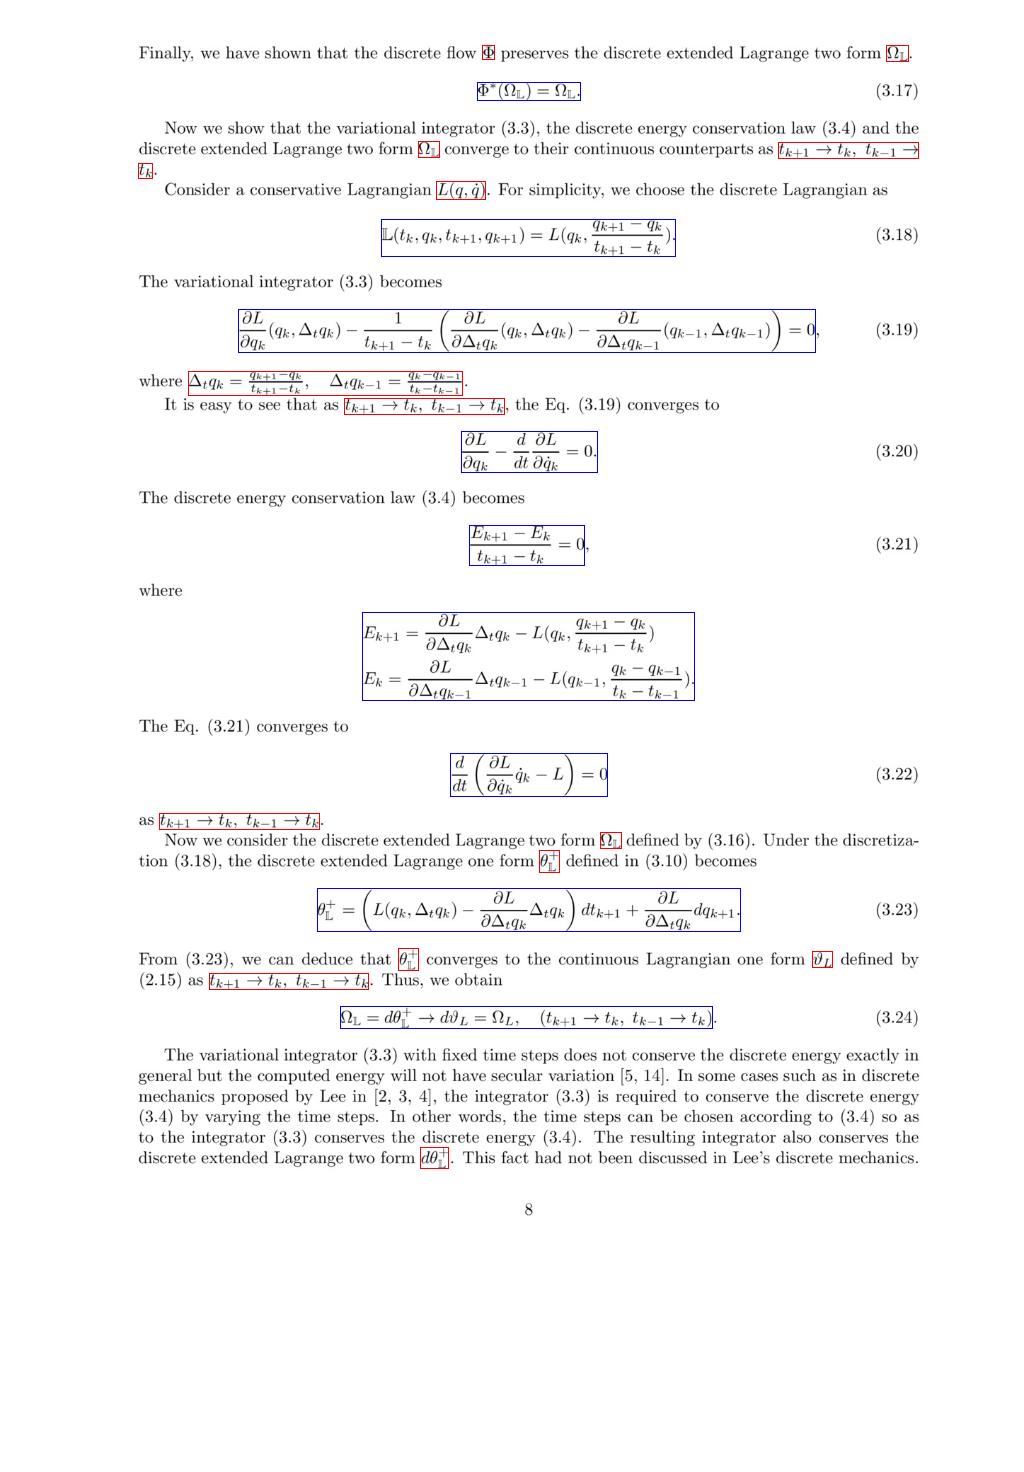

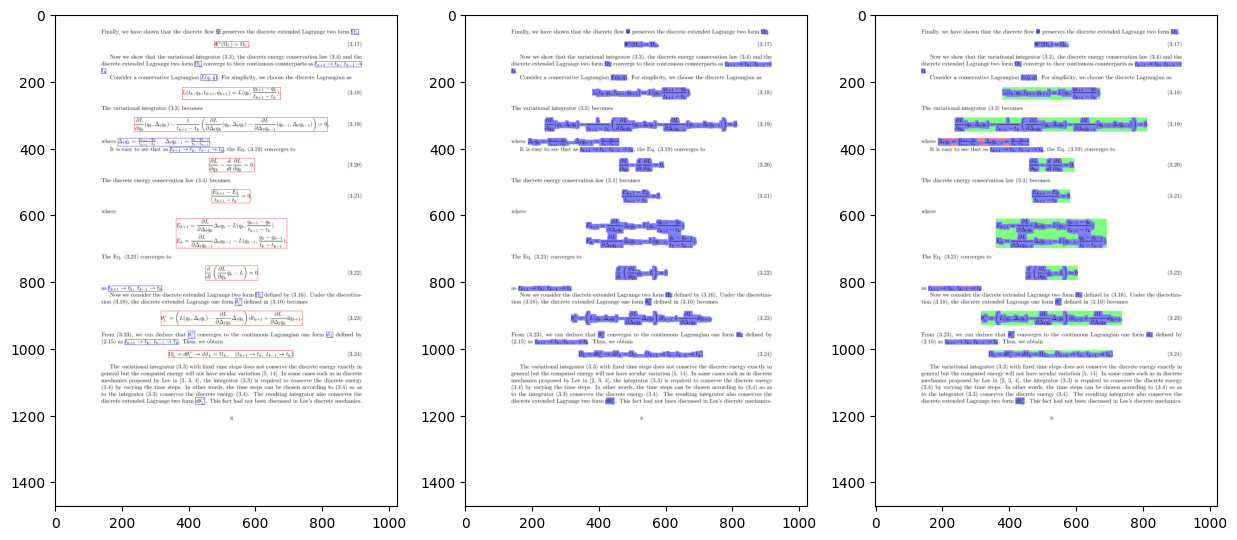

In [9]:
import yaml

def GetLabel(yaml_file):
    class_names = []
    with open(yaml_file, "r", encoding="utf-8") as stream:
        try:
            data_loaded = yaml.safe_load(stream)
            #print(data_loaded['names'])
            class_names = list(data_loaded['names'].values())
        except yaml.YAMLError as exc:
            print(exc)
    return class_names


def Txt2Regions(txt_fn, img):
    img_h, img_w = img.shape[:2]
    # ground truth math expressions
    Regions = []
    with open(txt_fn, 'r') as f:
        for i, line in enumerate(f.readlines()):
            line = line.strip('\n').split(' ')
            label = int(float(line[0]))

            nPoints = (len(line)-1)//2
            if nPoints == 2: # detection
                x, y = float(line[1]), float(line[2])
                w, h = float(line[3]), float(line[4])
                l, t = x - w/2, y - h/2
                r, b = x + w/2, y + h/2
                l, t = int(l*img_w), int(t*img_h)
                r, b = int(r*img_w), int(b*img_h)

                Regions.append(Region(str(label), l, t, r, b))
            else: # segmentation
                cnt, cnt2 = [], []
                for p in range(nPoints):
                    x = float(line[2*p+1])
                    y = float(line[2*p+2])
                    cnt.append(int(x*img_w+1))
                    cnt.append(int(y*img_h-1))
                    cnt2.append([int(x*img_w+1), int(y*img_h-1)])

                cnt = np.asarray(cnt)
                cnt2 = np.asarray(cnt2)
                x,y,w,h = cv2.boundingRect(cnt2)
                Regions.append(Region(str(label), x, y, x+w, y+h, poly=cnt))

    return Regions

data_yaml = '/content/IBEM/IBEM.yaml'
class_names = GetLabel(data_yaml)
num_classes = len(class_names)
print(class_names)

def IBEMLoad(img_fn):
    # image
    img = cv2.imread(img_fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # regions
    txt_fn = img_fn.replace('images', 'labels').replace('.jpg', '.txt')
    RegionsGT = Txt2Regions(txt_fn, img)

    # adjust regions
    bw = Binary(img)
    RegionsGT = AdjustGTs(RegionsGT, bw)

    return img, RegionsGT

# View data
ViewData(IBEM_Ts11_Files[115], IBEMLoad)

# ...and test

In [10]:
# copy checkpoints
!mkdir Ckpts
!cp drive/MyDrive/DataUSTH/MEDNet/Ckpts/*.* Ckpts > /dev/null


In [19]:
# Load model
model.load_weights('/content/Ckpts/IBEM_LA21_S133.h5')


[19.  7.] [19.  7.] [17.  7.]


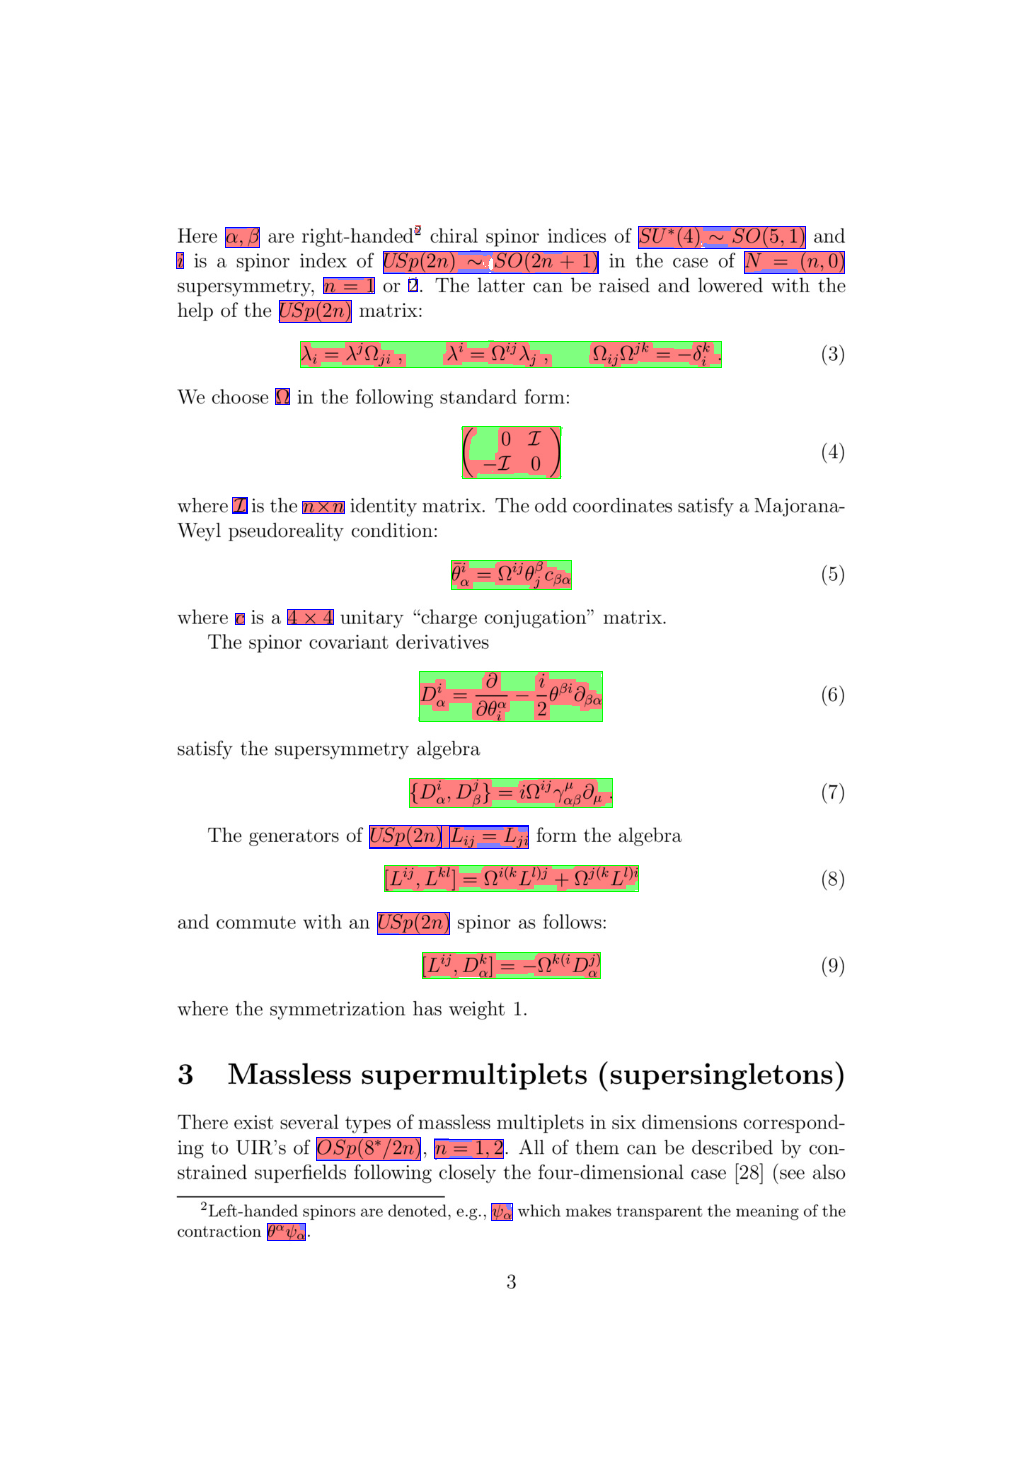

In [20]:
# sample test
LoadDataFunct = IBEMLoad
out = SampleTest(model, IBEM_Ts11_Files[0], num_classes, thresh=0.7)


In [ ]:
# model test
ModelTest(model, IBEM_Ts11_Files, num_classes, thresh=0.7)

# Marmot...

In [ ]:
!mkdir MM

!unzip drive/MyDrive/DataUSTH/MEDNet/MM/Train.zip -d MM > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/MM/Test.zip -d MM > /dev/null


mkdir: cannot create directory ‘MM’: File exists


In [ ]:
Folder_Train = '/content/MM/Train'
Folder_Test  = '/content/MM/Test'

MMTrainFiles = GetFiles([Folder_Train], 'xml')
MMTestFiles  = GetFiles([Folder_Test], 'xml')

print(len(MMTrainFiles), len(MMTestFiles))

330 70


In [ ]:
# data API
class_names = ['Embedded', 'Isolated']
num_classes = len(class_names)
print(class_names)

def Pdf2Imgs(pdf_fn, dpi=150, w=0, h=0):
    # pdf to page images
    if w > 0 and h > 0:
        images = convert_from_path(pdf_fn, dpi, size=(w, h))
    else:
        images = convert_from_path(pdf_fn, dpi, use_cropbox=True)
    for i in range(len(images)):
        images[i] = np.array(images[i])
    return images

def MMXml2Regions(xml_fn, img):
    img_h, img_w = img.shape[:2]
    # read regions from xml file
    tree = ET.parse(xml_fn)
    root = tree.getroot()

    Regions = []
    for page in root.iter('Page'):
        px0, py1, px1, py0 = list(map(hex_to_double, page.get("BBox").split()))
        pw = abs(px1 - px0)
        ph = abs(py1 - py0)

        for reg in page.iter('EmbeddedFormula'):
            x0p, y1m, x1p, y0m = list(map(hex_to_double, reg.get("BBox").split()))
            x0 = round(img_w*(x0p - px0)/pw)
            y0 = round(img_h*(py1 - y1m)/ph)
            x1 = round(img_w*(x1p - px0)/pw)
            y1 = round(img_h*(py1 - y0m)/ph)
            Regions.append(Region('0', x0, y0, x1, y1))

        for reg in page.iter('IsolatedFormula'):
            x0p, y1m, x1p, y0m = list(map(hex_to_double, reg.get("BBox").split()))
            x0 = round(img_w*(x0p - px0)/pw)
            y0 = round(img_h*(py1 - y1m)/ph)
            x1 = round(img_w*(x1p - px0)/pw)
            y1 = round(img_h*(py1 - y0m)/ph)
            Regions.append(Region('1', x0, y0, x1, y1))

    return Regions

def MMBK2Load(xml_fn):
    png_fn = xml_fn.replace('.xml', '.png')
    img = cv2.imread(png_fn)

    # regions
    RegionsGT = MMXml2Regions(xml_fn, img)

    return img, RegionsGT


# test
ViewData(MMTestFiles[16], MMBK2Load)
#ViewData(MMTrainFiles[0], MMBK2Load)

# ...and test

In [ ]:
# Log and checkpoint folder
model.load_weights('/content/Ckpts/MM_LA21_S133.h5')

In [ ]:
# sample test
LoadDataFunct = MMBK2Load
out = SampleTest(model, MMTestFiles[0], num_classes, thresh=0.5)


In [ ]:
# model test
ModelTest(model, MMTestFiles, num_classes, thresh=0.5)

# TFD...

In [ ]:
!mkdir TFD

!unzip drive/MyDrive/DataUSTH/MEDNet/TFD/Train.zip -d TFD > /dev/null
!unzip drive/MyDrive/DataUSTH/MEDNet/TFD/Test.zip -d TFD > /dev/null


In [ ]:
class_names = ['Formula']
num_classes = len(class_names)
print(class_names)

TFDi_Train = '/content/TFD/Train'
TFDi_Test  = '/content/TFD/Test'

TFDiTrainFiles = GetFiles([TFDi_Train], 'csv')
TFDiTestFiles  = GetFiles([TFDi_Test], 'csv')

print(len(TFDiTrainFiles), len(TFDiTestFiles))

['Formula']
284 176


In [ ]:
def TFDiLoad(csv_fn):
    # image
    img_fn = csv_fn.replace('.csv', '.png')
    img = cv2.imread(img_fn)
    # regions
    RegionsGT = read_csv(csv_fn)

    return img, RegionsGT

def read_csv(filename):
    Regions = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            rg = Region(row[0], int(row[1]), int(row[2]), int(row[3]), int(row[4]), None)
            Regions.append(rg)

    return Regions

# test
ViewData(TFDiTestFiles[13], TFDiLoad)

# ... and test

In [ ]:
# build model
num_classes = 1
model = BuildModel() # no emdedded and isolated distinction

# load model
model.load_weights('/content/Ckpts/TFD_LA21_S133.h5')

In [ ]:
# sample test
LoadDataFunct = TFDiLoad
out = SampleTest(model, TFDiTestFiles[0], num_classes, thresh=0.5)

In [ ]:
ModelTest(model, TFDiTestFiles, num_classes, thresh=0.5)

# Train models

In [15]:
seg_c = 4
LoadDataFunct = IBEMLoad
def DataGenerator(FileNames, scale1, scale2, bDataAug):
    nData = len(FileNames)
    scale1 = 2**scale1
    scale2 = 2**scale2

    IDs = np.random.permutation(nData)
    i = 0
    while True:
        # permute data
        if i + 1 > nData:
            IDs = np.random.permutation(nData)
            i = 0
        # take sample
        fn = FileNames[IDs[i]]
        i += 1

        # load image and masks
        img_fn = fn.decode("utf-8")
        img, y_seg, y_det,_ = MEDLoadData(img_fn, LoadDataFunct, INPUT_H, INPUT_W, INPUT_C)

        # data augmentation
        if bDataAug:
            img, y_seg, y_det = DataAug(img, y_seg, y_det)
            if img.ndim < 3:
                img = np.expand_dims(img, axis=-1)

        #  output sizes
        y_det  = tf.image.resize(y_det, (INPUT_H//scale1, INPUT_W//scale1), method='bilinear')
        y_seg2 = tf.image.resize(y_seg, (INPUT_H//scale2, INPUT_W//scale2), method='bilinear')

        # int to float
        img = np.array(img)
        y_seg = np.array(y_seg)
        y_det = np.array(y_det)
        y_seg2 = np.array(y_seg2)

        img = Norm(img)
        y_seg = Norm(y_seg)
        y_det = Norm(y_det)
        y_seg2 = Norm(y_seg2)

        #yield img, {'y': y_seg, 'y2': y_seg2}
        yield img, {'y': y_seg, 'y1': y_det, 'y2': y_seg2}


def Files2DS(Files, bDataAug=False, bsize=1):
    DS = tf.data.Dataset.from_generator(DataGenerator, args=[Files, scale1, scale2, bDataAug],
                                        output_types=(tf.float32, {'y': tf.float32, 'y1': tf.float32, 'y2': tf.float32}),
                                        output_shapes=((INPUT_H, INPUT_W, INPUT_C),
                                                       {'y': (INPUT_H, INPUT_W, seg_c),
                                                        'y1': (INPUT_H//(2**scale1), INPUT_W//(2**scale1), 2),
                                                        'y2': (INPUT_H//(2**scale2), INPUT_W//(2**scale2), seg_c)}))

    DS = DS.batch(bsize).prefetch(tf.data.AUTOTUNE)
    return DS


In [ ]:
EPOCHS = 200
BATCH_SIZE = 2
bDataAug = False
ModelCkpt = 'MEDNet.weights.h5'

def Train(model, TrainFiles, Epochs, ValFiles=None):
    if ValFiles is not None:
        # train data
        TrainDS = Files2DS(TrainFiles, bDataAug=bDataAug, bsize=BATCH_SIZE)
        nDataTrain = len(TrainFiles)

        # val data
        ValDS = Files2DS(ValFiles, bDataAug=False, bsize=BATCH_SIZE)
        nDataVal = len(ValFiles)

        # checkpoint
        Checkpoint = ModelCheckpoint(ModelCkpt, monitor='val_y_' + metric,
                                     mode='max', save_weights_only=True, save_best_only=True, verbose=1)
        CallBacks = [Checkpoint]

        # train with fit
        H = model.fit(TrainDS, steps_per_epoch=nDataTrain//BATCH_SIZE, epochs=Epochs,
                      validation_data=ValDS, validation_steps=nDataVal//BATCH_SIZE, validation_freq=1,
                      callbacks=CallBacks, verbose=1)
    else:
        ROUNDS = 1
        nFold = 3
        nVal_k = nDataTrain // nFold
        EPOCHS = Epochs // nFold

        for r in range(ROUNDS):
            for k in range(nFold):
                ValFiles = TrainFiles[nVal_k*k:nVal_k*(k+1)]
                Train(model, TrainFiles, Epochs, ValFiles=ValFiles)

# IBEM data
TrainFolders = [IBEM_Tr00, IBEM_Tr01, IBEM_Tr10]
TrainFiles = GetFiles(TrainFolders, 'jpg')

ValFolders = [IBEM_Va00, IBEM_Va01]
ValFiles = GetFiles(ValFolders, 'jpg')

# build the model
model = BuildModel()
Train(model, TrainFiles, EPOCHS, ValFiles=ValFiles)
